In [1]:
import sys
sys.path.append('/kaggle/input/alexnet/pytorch/baseline/1')
import torch
import torch.nn as nn
from torchvision import datasets
from baseline.model import AlexNetBaseline, init_params
from baseline.data_transforms import prepreprocess, get_preprocess, get_train_augment
from baseline.train import train
import matplotlib.pyplot as plt
from baseline.eval import top1_k 

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
train_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=True, download=True, transform=prepreprocess)
preprocess = get_preprocess(train_dataset)

train_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=True, transform=preprocess)
train_augment = get_train_augment(train_dataset, preprocess)

train_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=True, transform=train_augment)

val_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=False, transform=preprocess)
val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.5, 0.5])

print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

100%|██████████| 169001437/169001437 [00:03<00:00, 45117549.75it/s]


Extracting datasets/cifar100/cifar-100-python.tar.gz to datasets/cifar100
Mean:
[129.3524932861328, 124.11785888671875, 112.48182678222656]
Covar:
tensor([[4466.8828, 3691.4419, 3255.9656],
        [3691.4419, 4100.6714, 3917.4558],
        [3255.9656, 3917.4558, 4785.5786]], device='cuda:0')
Eigen values (sqrt):
tensor([[ 16.9473],
        [ 36.9707],
        [108.1623]])
Eigen vectors:
tensor([[ 0.3831,  0.7334,  0.5616],
        [-0.8158, -0.0165,  0.5780],
        [ 0.4332, -0.6796,  0.5920]])
Number of classes: 100
Train samples: 50000
Validation samples: 5000
Test samples: 5000


In [4]:
model = AlexNetBaseline(len(train_dataset.classes))
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    model = nn.DataParallel(model)
model.to(device)
# initialize parameters
init_params(model)
compiled_model = model
# if torch.cuda.is_available():
#     compiled_model = torch.compile(model)

In [5]:
costs, val_error_rates, learning_rates = train(
    compiled_model,
    train_dataset=train_dataset,
    cv_dataset=val_dataset,
    batch_size=128,
    num_epochs=100,
    initial_lr=0.01,
    num_workers=3,
    patience=10
)

Epoch 1/100, Cost: 4.2368735, Val Error: 89.42%, lr: 0.01, Time: 111s
Epoch 2/100, Cost: 3.5958828, Val Error: 78.94%, lr: 0.01, Time: 111s
Epoch 3/100, Cost: 3.1503169, Val Error: 69.42%, lr: 0.01, Time: 116s
Epoch 4/100, Cost: 2.8221710, Val Error: 68.36%, lr: 0.01, Time: 110s
Epoch 5/100, Cost: 2.5625068, Val Error: 60.58%, lr: 0.01, Time: 107s
Epoch 6/100, Cost: 2.3634549, Val Error: 55.96%, lr: 0.01, Time: 111s
Epoch 7/100, Cost: 2.2010790, Val Error: 52.16%, lr: 0.01, Time: 110s
Epoch 8/100, Cost: 2.0723920, Val Error: 50.78%, lr: 0.01, Time: 111s
Epoch 9/100, Cost: 1.9592036, Val Error: 48.76%, lr: 0.01, Time: 111s
Epoch 10/100, Cost: 1.8804885, Val Error: 48.54%, lr: 0.01, Time: 112s
Epoch 11/100, Cost: 1.7902044, Val Error: 45.14%, lr: 0.01, Time: 111s
Epoch 12/100, Cost: 1.7066609, Val Error: 44.90%, lr: 0.01, Time: 109s
Epoch 13/100, Cost: 1.6547812, Val Error: 45.86%, lr: 0.01, Time: 112s
Epoch 14/100, Cost: 1.5998650, Val Error: 44.16%, lr: 0.01, Time: 108s
Epoch 15/100, C

In [6]:
torch.save(model.state_dict(), 'baseline_cifar100.model.pt')
torch.save(preprocess, 'baseline_cifar100.preprocess.pt')
torch.save(train_augment, 'baseline_cifar100.train_augment.pt')

In [7]:
test_top1, test_top5 = top1_k(compiled_model, test_dataset, k=5)
print(f'Test Top 1: {test_top1}')
print(f'Test Top 5: {test_top5}')

val_top1, val_top5 = top1_k(compiled_model, val_dataset, k=5)
print(f'Val Top 1: {val_top1}')
print(f'Val Top 5: {val_top5}')

train_eval_dataset = datasets.CIFAR100(
    'datasets/cifar100', train=True, transform=preprocess)
train_top1, train_top5 = top1_k(compiled_model, train_eval_dataset, k=5)
print(f'Train Top 1: {train_top1}')
print(f'Train Top 5: {train_top5}')

Test Top 1: 0.6862
Test Top 5: 0.8914
Val Top 1: 0.6898
Val Top 5: 0.8944
Train Top 1: 0.99902
Train Top 5: 1.0


Text(0.5, 1.0, 'Costs')

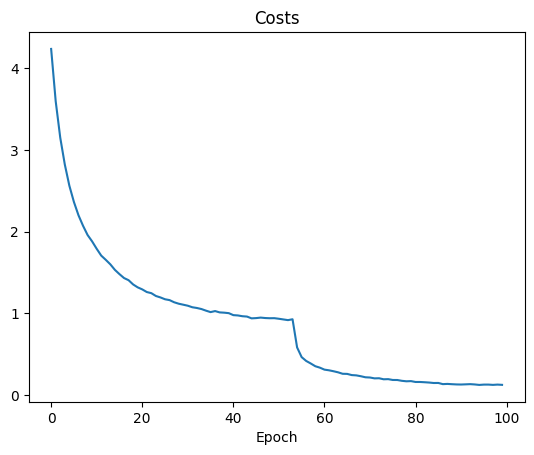

In [8]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.title('Costs')

Text(0.5, 1.0, 'Validation Error Rates')

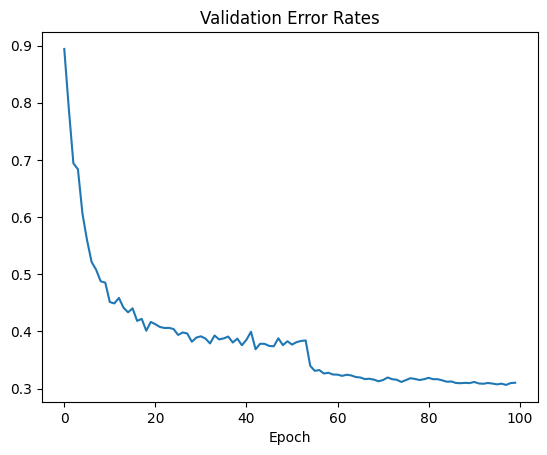

In [9]:
plt.plot(val_error_rates)
plt.xlabel("Epoch")
plt.title('Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

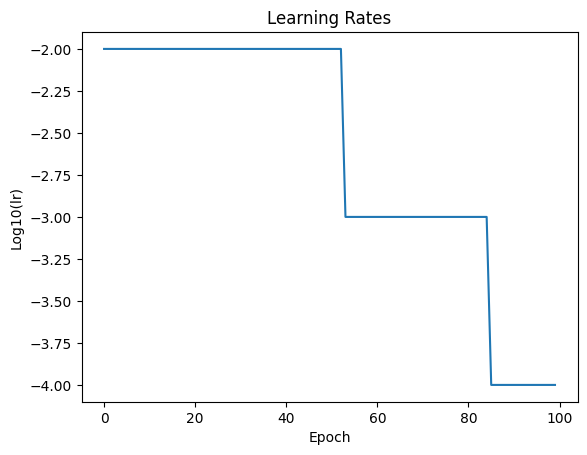

In [10]:
import math

plt.plot([math.log10(lr) for lr in learning_rates])
plt.ylabel("Log10(lr)")
plt.xlabel("Epoch")
plt.title('Learning Rates')